Total rows: 242,160
Malicious days: 21

ANNUAL INSIDER THREAT PROBABILITY BY ROLE
Role                    Employees  Users w/ Incident     Annual %
----------------------------------------------------------------------
C_Level                         9                  0        0.00%
Trader                        100                  2        2.00%
IT_Admin                       50                  1        2.00%
Analyst                       700                 10        1.43%
Contractor                    130                  8        6.15%
Exec_Assistant                 20                  0        0.00%


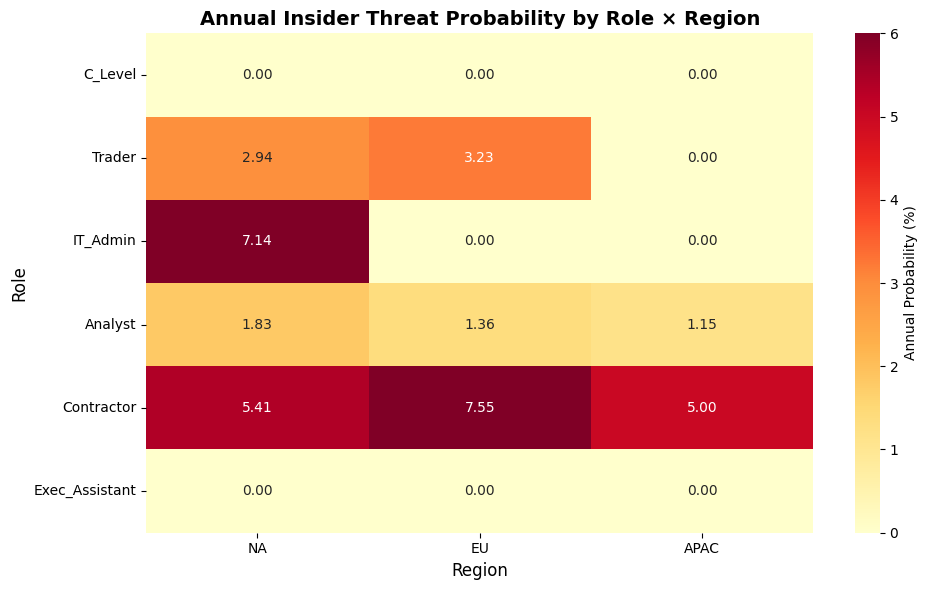

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

OUTPUT_DIR = Path("risk_analysis")
OUTPUT_DIR.mkdir(exist_ok=True)  


# Configuration
ROLES = ["C_Level", "Trader", "IT_Admin", "Analyst", "Contractor", "Exec_Assistant"]
REGIONS_ORDER = ["NA", "EU", "APAC"]
ROLE_HEADCOUNT = {
    "C_Level": 9,
    "Analyst": 700,
    "Trader": 100,
    "IT_Admin": 50,
    "Exec_Assistant": 20,
    "Contractor": 130
}
N_ITER = 10000
RANDOM_STATE = 42

# INSIDER THREAT RISK ANALYSIS - STATISTICAL APPROACH

# Load data
df = pd.read_csv("billybank_activity_updated.csv", keep_default_na=False)
df['region'] = df['region'].replace({np.nan: "NA"})

print(f"Total rows: {len(df):,}")
print(f"Malicious days: {df['is_malicious'].sum():,}")

# Calculate annual probability = (# users with ≥1 malicious day) / (total users)
user_had_incident = df.groupby(['user_id', 'role', 'region'])['is_malicious'].agg([
    ('had_incident', lambda x: int(x.sum() > 0))
]).reset_index()

# Calculate probability by role
role_annual = (
    user_had_incident.groupby('role')['had_incident']
    .mean()  # Proportion of users who had ≥1 incident
    .reindex(ROLES)
)

# Role × Region breakdown
role_region_annual = (
    user_had_incident.groupby(['role', 'region'])['had_incident']
    .mean()
    .unstack()
    .reindex(index=ROLES, columns=REGIONS_ORDER, fill_value=0.0)
)

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    role_region_annual * 100,
    annot=True, 
    fmt=".2f",
    cmap="YlOrRd",
    vmin=0,
    vmax=6,  # Cap at 6% for better visualization
    cbar_kws={'label': 'Annual Probability (%)'}
)
plt.title("Annual Insider Threat Probability by Role × Region", fontsize=14, fontweight='bold')
plt.ylabel("Role", fontsize=12)
plt.xlabel("Region", fontsize=12)
plt.tight_layout()
plot_path = OUTPUT_DIR / 'risk_heatmap.jpg'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', format="jpeg")
plt.show()

risk_scores_per_region = role_region_annual * 100  # Convert to percentage

# Flatten the data for better CSV format
risk_csv = []
for role in risk_scores_per_region.index:
    for region in risk_scores_per_region.columns:
        risk_csv.append({
            'role': role,
            'region': region,
            'annual_probability_percent': risk_scores_per_region.loc[role, region],
            'headcount': ROLE_HEADCOUNT.get(role, 0)
        })

risk_df = pd.DataFrame(risk_csv)
csv_path = OUTPUT_DIR / 'risk_scores_by_region.jpg'
risk_df.to_csv(csv_path, index=False)



  Features: 48 total
  Target: Binary classification (insider threat: yes/no)

--------------------------------------------------------------------------------
TOP 15 BEHAVIORAL INDICATORS OF INSIDER THREATS
--------------------------------------------------------------------------------
Rank     Importance Behavioral Indicator                                        
--------------------------------------------------------------------------------
1             20.7%  Sensitive File Reads (Peak)                                 
2              8.9%  Sensitive File Reads (Variability)                          
3              6.6%  Emails With Attachments (Peak)                              
4              5.2%  Emails With Attachments (Avg)                               
5              3.8%  Cloud Upload Events (Variability)                           
6              3.4%  External Emails Sent (Peak)                                 
7              3.3%  Usb Device Mounts (Variability)    

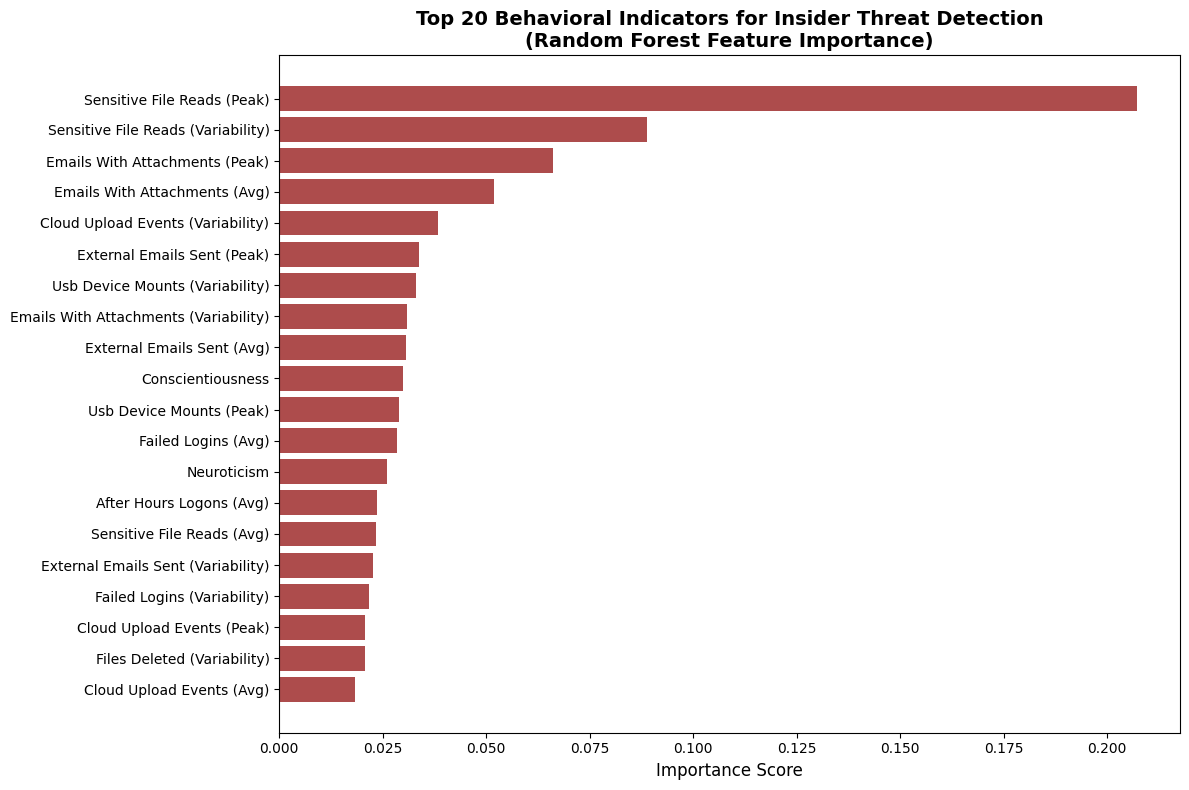

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from pathlib import Path

OUTPUT_DIR = Path("ml_output")
OUTPUT_DIR.mkdir(exist_ok=True)  


# MACHINE LEARNING FOR INSIDER THREAT BEHAVIORAL ANALYSIS

df = pd.read_csv("billybank_activity_updated.csv", keep_default_na=False)
df['region'] = df['region'].replace({np.nan: "NA"})

# Behavioral features from daily logs
behavioral_features = [
    'after_hours_logons',
    'sensitive_file_reads', 
    'usb_device_mounts',
    'external_emails_sent',
    'emails_with_attachments',
    'cloud_upload_events',
    'failed_logins',
    'files_deleted',
    'http_competitor_visits'
]

# Aggregate to user level with statistical features
user_profiles = []

for user_id, user_df in df.groupby('user_id'):
    profile = {
        'user_id': user_id,
        'role': user_df['role'].iloc[0],
        'region': user_df['region'].iloc[0],
        'conscientiousness': user_df['conscientiousness'].iloc[0],
        'neuroticism': user_df['neuroticism'].iloc[0],
        
        # Did this user become an insider threat?
        'is_insider_threat': int(user_df['is_malicious'].sum() > 0),
        'num_malicious_days': user_df['is_malicious'].sum()
    }
    
    # Create statistical features from 240 days of behavior
    for feat in behavioral_features:
        profile[f'{feat}_mean'] = user_df[feat].mean()      # Average behavior
        profile[f'{feat}_max'] = user_df[feat].max()        # Peak behavior (spikes!)
        profile[f'{feat}_std'] = user_df[feat].std()        # Variability
        profile[f'{feat}_90th'] = user_df[feat].quantile(0.90)  # Top 10% of days
    
    profile['hr_flag_rate'] = user_df['is_hr_flagged'].mean()
    user_profiles.append(profile)

user_df = pd.DataFrame(user_profiles)


# Training machine learning model

# Prepare features
feature_cols = [col for col in user_df.columns 
                if col not in ['user_id', 'is_insider_threat', 'num_malicious_days', 
                               'role', 'region']]

# One-hot encode categorical variables
X = pd.get_dummies(user_df[feature_cols + ['role', 'region']], 
                   columns=['role', 'region'], drop_first=False)
y = user_df['is_insider_threat']


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest (better performance, feature importance)
model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
model_rf.fit(X_train_scaled, y_train)
    
# Use Random Forest for final analysis (better performance)
model = model_rf
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# FEATURE IMPORTANCE - "WHICH BEHAVIORS MATTER?"

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Clean up feature names for readability
def clean_feature_name(feat):
    """Make feature names readable for executives"""
    feat = feat.replace('_mean', ' (avg)')
    feat = feat.replace('_max', ' (peak)')
    feat = feat.replace('_std', ' (variability)')
    feat = feat.replace('_90th', ' (90th percentile)')
    feat = feat.replace('_', ' ')
    feat = feat.replace('role ', 'Role: ')
    feat = feat.replace('region ', 'Region: ')
    return feat.title()

feature_importance['feature_clean'] = feature_importance['feature'].apply(clean_feature_name)

# Top 15 most important features
top_features = feature_importance.head(15)

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'], color='darkred', alpha=0.7)
plt.yticks(range(len(top_20)), top_20['feature_clean'], fontsize=10)
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 20 Behavioral Indicators for Insider Threat Detection\n(Random Forest Feature Importance)', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plot_path = OUTPUT_DIR / 'feature_importance.jpg'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', format="jpeg")
plt.show()


# BEHAVIORAL PROFILE COMPARISON
# How insider threats behave differently vs. normal users
# Compare insiders vs. non-insiders
insiders = user_df[user_df['is_insider_threat'] == 1]
non_insiders = user_df[user_df['is_insider_threat'] == 0]

# Focus on top behavioral features
key_behaviors = [
    'sensitive_file_reads_max',
    'emails_with_attachments_max',
    'external_emails_sent_max',
    'cloud_upload_events_max',
    'after_hours_logons_max'
]

comparison = []
for feat in key_behaviors:
    comparison.append({
        'Behavior': clean_feature_name(feat),
        'Normal Users (avg)': non_insiders[feat].mean(),
        'Insider Threats (avg)': insiders[feat].mean(),
        'Difference': insiders[feat].mean() - non_insiders[feat].mean(),
        'Ratio': insiders[feat].mean() / non_insiders[feat].mean() if non_insiders[feat].mean() > 0 else 0
    })

comparison_df = pd.DataFrame(comparison)

# Behavioral comparison
csv_path = OUTPUT_DIR / 'ml_behavioral_comparison.csv'

comparison_df.to_csv(csv_path, index=False)
